# LLMs Assignment- IMDB Sentiment Analysis Dataset- Mohamed Helayhel

In [70]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.datasets import imdb 

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences

## Load Dataset- IMDB
The IMDB dataset is a collection of 50,000 movie reviews from the Internet Movie Database (IMDB) that have been preprocessed and labeled by sentiment (positive/negative). The dataset is split into 25,000 reviews for training and 25,000 reviews for testing. Reviews have been preprocessed, and each review is encoded as a list of word indexes (integers).

**Desired Output:** The objective is to analyze the words in a movie review sequentially and predict whether the review is positive or negative using LLM pre-trained models (BERT).

In [74]:
# Set the random seed for reproducibility
np.random.seed(42)

# Load data
(X_train, y_train), (X_test, y_test) = imdb.load_data()

In [76]:
X_train.shape

(25000,)

In [78]:
y_train.shape

(25000,)

In [80]:
X_test.shape

(25000,)

In [82]:
y_test.shape

(25000,)

In [ ]:
y_train[0:99]

In [2]:
!pip install transformers datasets --quiet

In [1]:
from transformers import pipeline, AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from datasets import load_dataset
import torch

In [4]:
# Load a sentiment-analysis pipeline
sentiment_pipeline = pipeline("sentiment-analysis", model="nlptown/bert-base-multilingual-uncased-sentiment")

# Analyze a few examples
examples = ["I love this movie. It was fantastic!", "The movie was boring and terrible."]
results = sentiment_pipeline(examples)

# Display results
for example, result in zip(examples, results):
    print(f"Text: {example}\nSentiment: {result}\n")

pytorch_model.bin:   0%|          | 0.00/669M [00:00<?, ?B/s]

Device set to use mps:0


Text: I love this movie. It was fantastic!
Sentiment: {'label': '5 stars', 'score': 0.9433344006538391}

Text: The movie was boring and terrible.
Sentiment: {'label': '1 star', 'score': 0.6183295249938965}



### Initial Exploration of BERT LLM Modeling
The code above uses the pre-trained sentiment analysis model pipeline with bert as a base from the transformers library on Hugging Face,

BERT (Bidirectional Encoder Representations from Transformers) is a transformer-based model designed for understanding the context of words in a sentence by considering both their left and right contexts simultaneously. It uses Masked Language Modeling (MLM), i.e. it randomly masks some words in a sentence and trains the model to predict them based on context. It also uses Next Sentence Prediction (NSP), i.e. predicts whether one sentence logically follows another, helping in understanding sentence relationships. It is an Encoder only model, which relies on the attention mechanism to weigh the importance of each word in a sequence relative to others. Above you can see an example of how BERT works to classify a sample review. It assigns a score, where a higher score corresponds to a better rating, and it correctly labels each review with a 5 star for the positive review and 1 start for the negative one.

In [7]:
!pip install torch torchvision torchaudio --quiet

### Further Exploration of Dataset

In [5]:
# Load IMDB dataset
dataset = load_dataset("imdb")

# Check the structure of the dataset
print(dataset)

# Convert to a DataFrame (for easier handling)
import pandas as pd
train_df = pd.DataFrame(dataset['train'])
test_df = pd.DataFrame(dataset['test'])

# Display a sample
print(train_df.head())

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label'],
        num_rows: 50000
    })
})
                                                text  label
0  I rented I AM CURIOUS-YELLOW from my video sto...      0
1  "I Am Curious: Yellow" is a risible and preten...      0
2  If only to avoid making this type of film in t...      0
3  This film was probably inspired by Godard's Ma...      0
4  Oh, brother...after hearing about this ridicul...      0


In [8]:
# Load a tokenizer (BERT tokenizer in this example)
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

# Tokenize a single example
sample_text = "This movie was absolutely fantastic!"
tokens = tokenizer(sample_text, padding="max_length", truncation=True, return_tensors="pt")

print(tokens)

{'input_ids': tensor([[  101,  2023,  3185,  2001,  7078, 10392,   999,   102,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,  

The code above shows how the tokenizer works on a single example. The BERT tokenizer uses WordPiece tokenization, which breaks words into subwords or characters if they are not in the vocabulary. It converts text to a sequence of token IDs while adding special tokens like [CLS] (classification) and [SEP] (separator). This allows BERT to handle out-of-vocabulary words and capture the contextual meaning of text efficiently.

In [2]:
from datasets import load_dataset

# Load IMDB dataset
dataset = load_dataset('imdb')

# Split dataset into train and test sets
train_data = dataset['train']
test_data = dataset['test']

In [4]:
from transformers import BertTokenizer

# Load pre-trained BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokenize and encode the text into input IDs
def encode_example(example):
    return tokenizer(example['text'], truncation=True, padding='max_length', max_length=128)

# Apply encoding to the dataset
train_data = train_data.map(encode_example, batched=True)
test_data = test_data.map(encode_example, batched=True)

# Format dataset for PyTorch
train_data.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])
test_data.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])

In [6]:
from transformers import BertForSequenceClassification, Trainer, TrainingArguments

# Load pre-trained BERT model for sequence classification
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### Model Design Summary
In the code above, the berttokenizer was imported and applied on the entire dataset. Pytorch was used to set the format of the data in such a way that takes input_ids, attention_mask, and label. Then, the model BertForSequenceClassification was imported from hugging face's transformers architecture, and the 'bert-base-uncased' was imported. The num_labels was set to 2 since it was done with goal of classification of reviews to only two categories: positive or negative.

In the code below, we design the specific model. Key elements are:
1. AdamW Optimizer Initialization: a variation of the Adam optimizer that decouples weight decay from the learning rate, which is particularly effective for transformer models like BERT. The lr=2e-5 is a typical learning rate for fine-tuning pre-trained models.
2. output_dir: Specifies where the model checkpoints and logs will be saved, which is 'results' in this case.
3. evaluation_strategy="epoch": Triggers evaluation after every epoch, which used for monitoring validation performance.
4. learning_rate: Although specified here, it is overridden by the explicit optimizer provided later.
5. weight_decay=0.01: Encourages smaller weights, which helps reduce overfitting.
6. per_device_train_batch_size and per_device_eval_batch_size: These values are typical but can be adjusted based on GPU memory capacity, as well as model performace

In [8]:
from transformers import AdamW

# Initialize AdamW optimizer
optimizer = AdamW(model.parameters(), lr=2e-5)

# Set up training arguments
training_args = TrainingArguments(
    output_dir='./results',
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir='./logs',
    report_to='none'
)

# Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_data,
    eval_dataset=test_data,
    optimizers=(optimizer, None),  # Use AdamW optimizer without learning rate scheduler
    
)

/opt/anaconda3/lib/python3.12/site-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [12]:
# Train the model
trainer.train()

Epoch,Training Loss,Validation Loss
1,0.301200,0.285079
2,0.198700,0.321723
3,0.105900,0.465134


TrainOutput(global_step=4689, training_loss=0.21579934549524882, metrics={'train_runtime': 1900.9856, 'train_samples_per_second': 39.453, 'train_steps_per_second': 2.467, 'total_flos': 4933332288000000.0, 'train_loss': 0.21579934549524882, 'epoch': 3.0})

### Comment on Model Above:
The model returned the lowest validation loss for the first epoch, which shows that it learned as much as it could from the first round. Future rounds show the model lowering its training loss but increasing its validation loss, a sign of overfitting.

In [28]:
# Evaluate the model
results = trainer.evaluate()

# Print results (accuracy, loss, etc.)
print(f"Test Loss: {results['eval_loss']}")
print(f"Test Accuracy: {results['eval_accuracy']}")

Test Loss: 0.46513429284095764


KeyError: 'eval_accuracy'

## Function to generate more comprehensive accuracy metrics

In [104]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    
    # Calculate accuracy
    accuracy = accuracy_score(labels, preds)

   # Calculate precision, recall, and F1-score
    precision = precision_score(labels, preds, average='weighted')
    recall = recall_score(labels, preds, average='weighted')
    f1 = f1_score(labels, preds, average='weighted')
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

### Same Model parameters as above: 1 Epoch instead of 3 

In [36]:
from transformers import AdamW

# Initialize AdamW optimizer
optimizer = AdamW(model.parameters(), lr=2e-5)

# Set up training arguments
training_args = TrainingArguments(
    output_dir='./results',
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    num_train_epochs=1,
    weight_decay=0.01,
    logging_dir='./logs',
    report_to='none'
)

# Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_data,
    eval_dataset=test_data,
    optimizers=(optimizer, None), # Use AdamW optimizer without learning rate scheduler
    compute_metrics=compute_metrics
)

### Comment on Model Above:
Given that the best learning happens in epoch 1, the next model only used 1 epoch and the training time was reduced from 31 mins to 13 minutes, a drastic improvement in terms of computational intensity. However, we see that the validation loss in this 1 epoch, despite keeping all other parameters similar, is higher than all 3 above. This is typical given the non-deterministic nature of LLMs.

In [38]:
# Fine-tune the model
trainer.train()

# Evaluate the fine-tuned model
results = trainer.evaluate()

# Print evaluation results
print(results)

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.060700,0.565154,0.886120,0.886187,0.886120,0.886115


{'eval_loss': 0.5651538968086243, 'eval_accuracy': 0.88612, 'eval_precision': 0.886187289273283, 'eval_recall': 0.88612, 'eval_f1': 0.8861150391711062, 'eval_runtime': 151.9552, 'eval_samples_per_second': 164.522, 'eval_steps_per_second': 2.573, 'epoch': 1.0}


In [56]:
# Fine-tune the model
trainer.train()

# Evaluate the fine-tuned model
results = trainer.evaluate()

# Print evaluation results
print(results)

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.068500,0.519798,0.885720,0.885724,0.885720,0.885720


{'eval_loss': 0.5197984576225281, 'eval_accuracy': 0.88572, 'eval_precision': 0.885724149774693, 'eval_recall': 0.88572, 'eval_f1': 0.8857196926316854, 'eval_runtime': 152.7045, 'eval_samples_per_second': 163.715, 'eval_steps_per_second': 2.561, 'epoch': 1.0}


### Comment on code above
Retraining the same model gave us slightly different accuracy results, again showcasing the non-deterministic nature of LLMs. 

### Using different Optimizer: SGD instead of AdamW

In [64]:
from torch.optim import SGD
# Initialize AdamW optimizer
optimizer = SGD(model.parameters(), lr=0.01, momentum=0.9)

# Set up training arguments
training_args = TrainingArguments(
    output_dir='./results',
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=64,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir='./logs',
    report_to='none'
)

# Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_data,
    eval_dataset=test_data,
    optimizers=(optimizer, None),
    compute_metrics=compute_metrics
)

In [66]:
# Fine-tune the model
trainer.train()

# Evaluate the fine-tuned model
results = trainer.evaluate()

# Print evaluation results
print(results)

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.044500,0.571688,0.876640,0.878998,0.876640,0.876448
2,0.059100,0.628698,0.883680,0.884325,0.883680,0.883631
3,0.028400,0.656673,0.887560,0.887692,0.887560,0.887550


{'eval_loss': 0.6566731929779053, 'eval_accuracy': 0.88756, 'eval_precision': 0.8876924009869381, 'eval_recall': 0.88756, 'eval_f1': 0.8875503993229732, 'eval_runtime': 207.9523, 'eval_samples_per_second': 120.22, 'eval_steps_per_second': 1.88, 'epoch': 3.0}


### Comment on code above:
Using SGD instead of AdamW presented similar results. The key reason for this is pre-trained Model Stability. Fine-tuning pre-trained models like BERT often leads to good results regardless of the optimizer because the model already has well-initialized parameters. This can reduce the observable differences between optimizers.

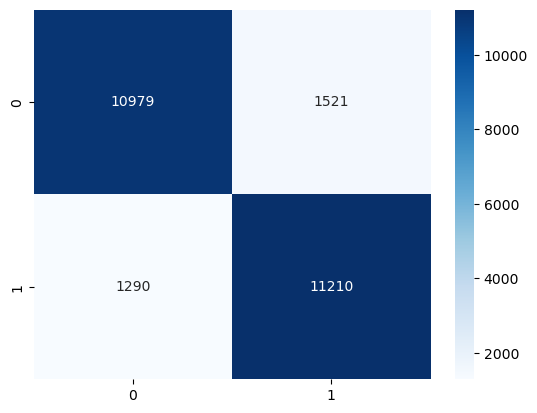

In [95]:
# If you want to evaluate confusion matrix:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Generate predictions for confusion matrix
predictions = trainer.predict(test_data)
y_true = test_data['label']
y_pred = predictions.predictions.argmax(axis=-1)

conf_matrix = confusion_matrix(y_true, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.show()

### Evaluation of Model+ future work
The confusion Matrix shows a fairly balanced case of both reading false positives and false negatives. This is unsurprising given BERT model's stability and its ability to understand context, so we shouldn't expect results to be skewed in either direction. Overall, the results are good, since the model, even with one epoch and minimal optimization was able to achieve an accuracy of almost 90% on a large test dataset of 25k samples, so the results are satisfactory given the computational limitations we faced. 

However, to further improve accuracy, we can consider the following steps:
1. Hyperparameter Tuning: Optimize learning rates, batch sizes, and number of epochs.
2. Learning Rate Scheduler: Use a scheduler (e.g., linear_schedule_with_warmup) for smoother convergence.
3. Data Augmentation: Add diversity through synonym replacement, back-translation, or random insertions.
4. Larger Dataset: Combine with similar datasets or perform unsupervised pretraining on domain-specific text.
5. Alternative Models: Experiment with models like RoBERTa or DistilBERT for potential accuracy gains.
7. Regularization: Increase dropout or adjust weight decay to prevent overfitting.
8. Metrics and Evaluation: Use metrics like F1-Score and ROC-AUC for deeper insights.
9. Ensemble Models: Combine predictions from multiple models for improved robustness.
10. Hardware Optimization: Enable mixed precision training or leverage multiple GPUs.